Opening file calibration1.jpg
(720, 1280, 3)
Opening file calibration10.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration11.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration12.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration13.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration14.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration15.jpg
(721, 1281, 3)
Debug: Found corners
Opening file calibration16.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration17.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration18.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration19.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration2.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration20.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration3.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration4.jpg
(720, 1280, 3)
Opening file calibration5.jpg
(720, 1280,

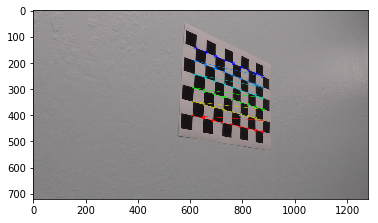

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
%matplotlib inline

# prepare object points
nx = 9
ny = 6


objpoints = [] # 3D points in the real world
imgpoints = [] # 2D points in the image plane

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

class calibration_mat:
    def __init__(self,ret,mtx,dist,rvecs,tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs
        
cal_folder = "./camera_cal"

for cal_file in os.listdir(cal_folder):
    img = cv2.imread(cal_folder + "/" + cal_file)
    print ("Opening file", cal_file)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print (img.shape)

    if ret == True:
        print ("Debug: Found corners")
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        imgpoints.append(corners)
        objpoints.append(objp)
    
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
cal_mat = calibration_mat(ret,mtx,dist,rvecs,tvecs)
dst = cv2.undistort(img, cal_mat.mtx, cal_mat.dist, None, cal_mat.mtx)
plt.imshow(dst)
for cal_file in os.listdir(cal_folder):
    img = cv2.imread(cal_folder + "/" + cal_file)
    undist = cv2.undistort(img, cal_mat.mtx, cal_mat.dist, None, cal_mat.mtx)
    cv2.imwrite("output_images/"+"undist_"+cal_file, undist)



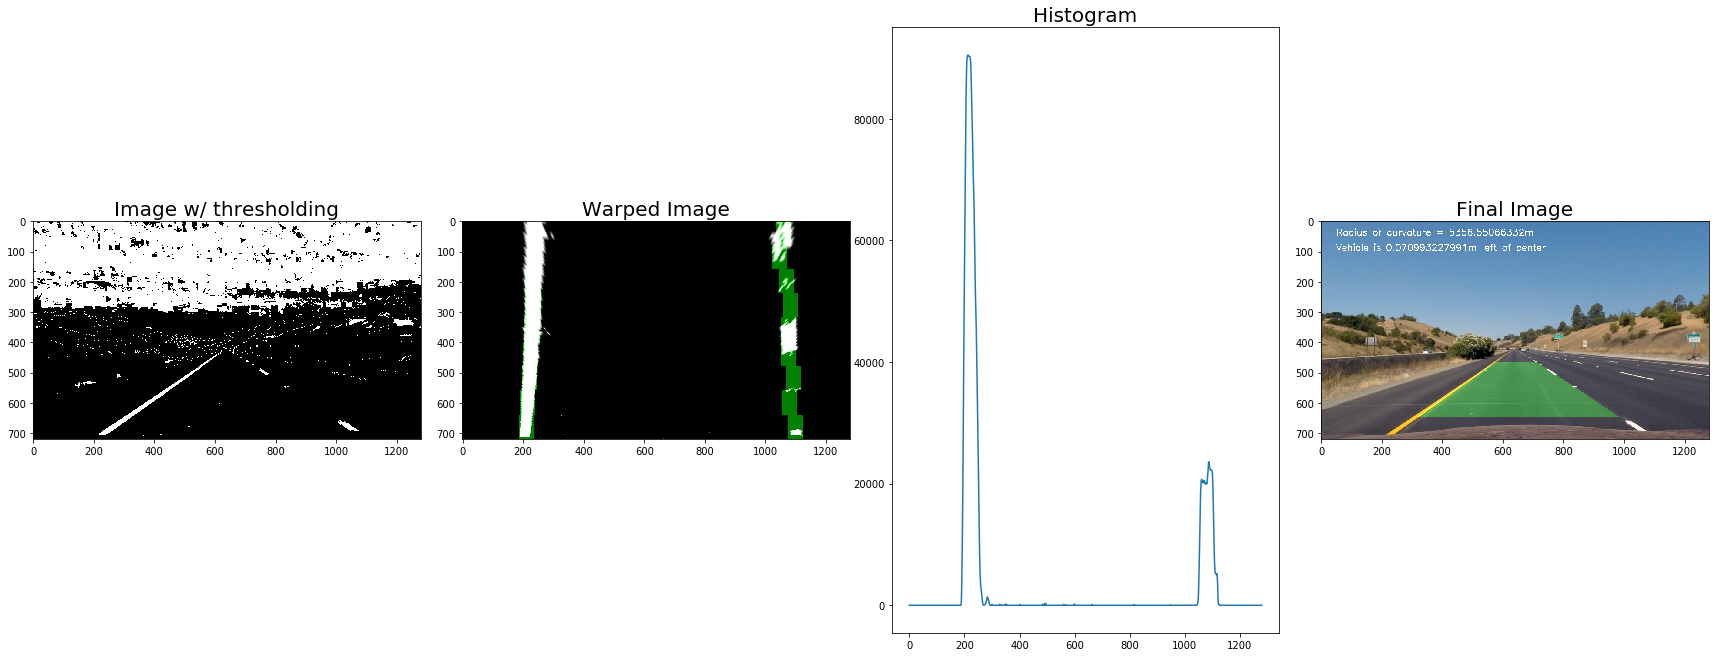

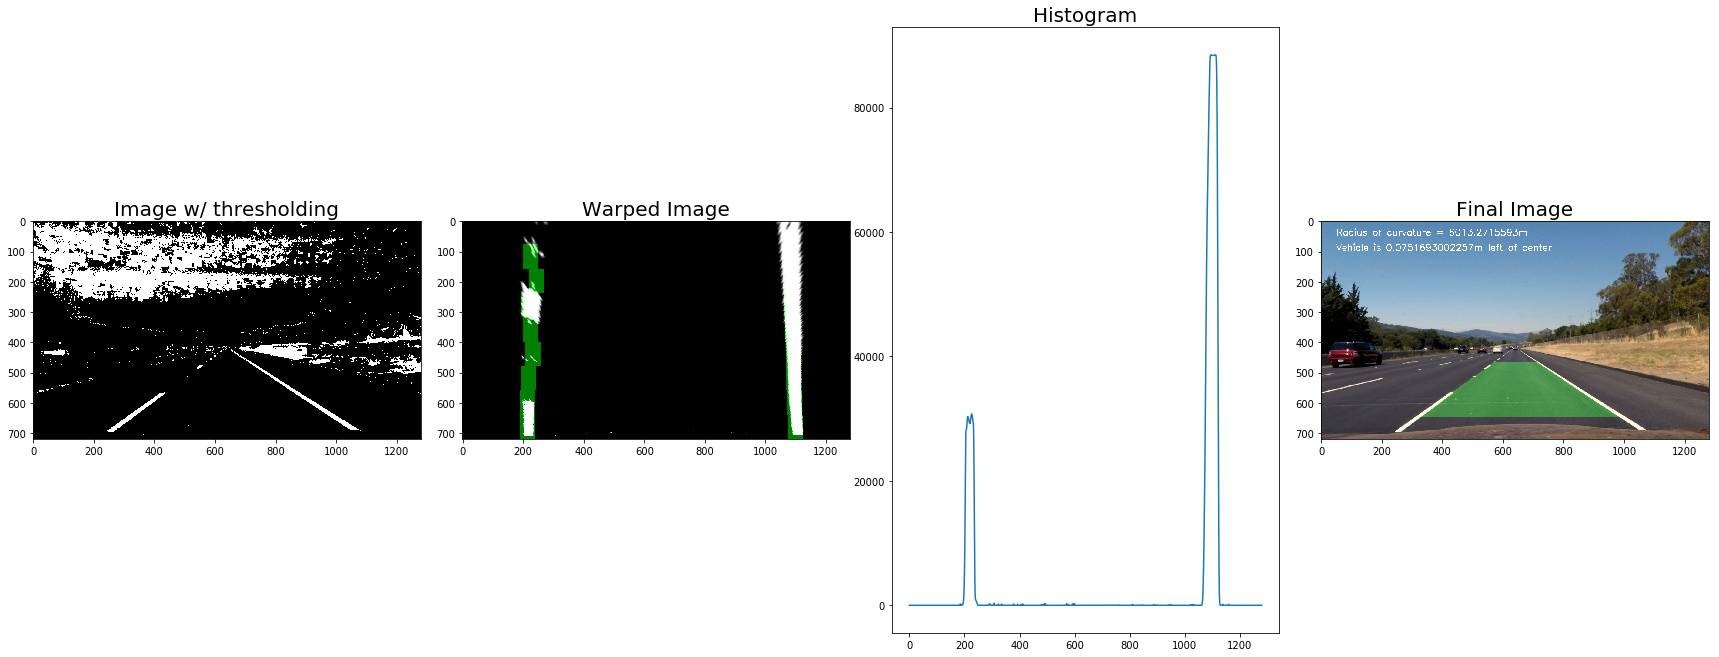

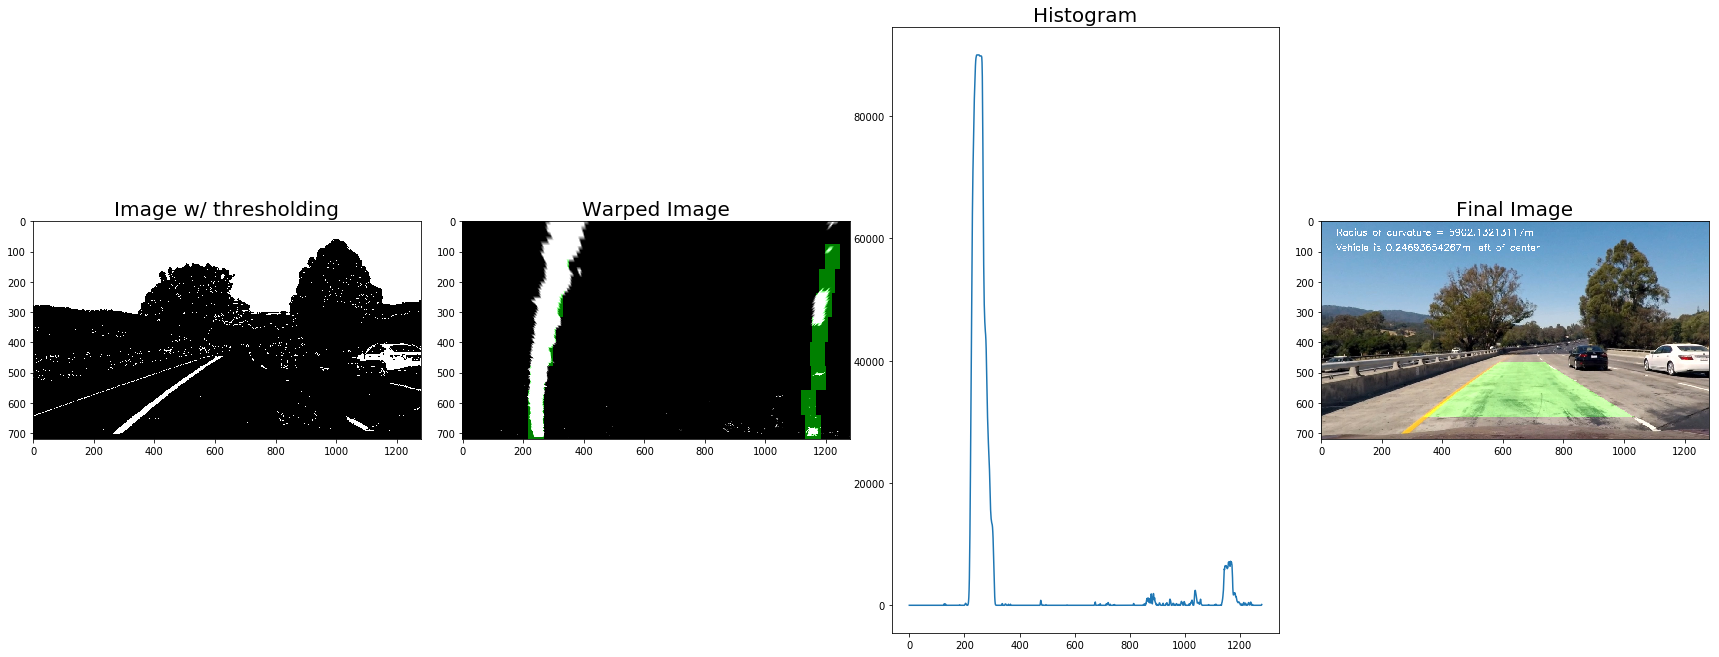

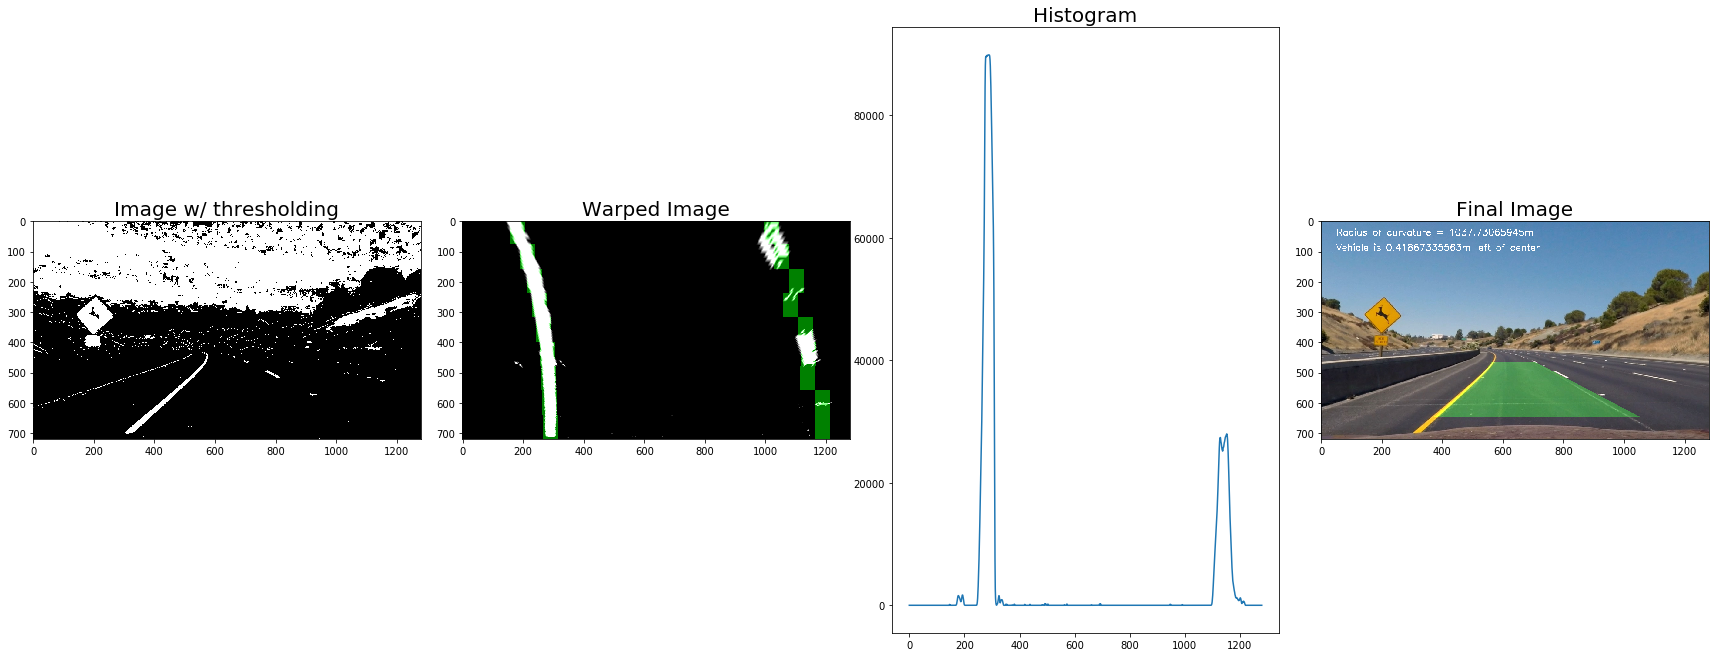

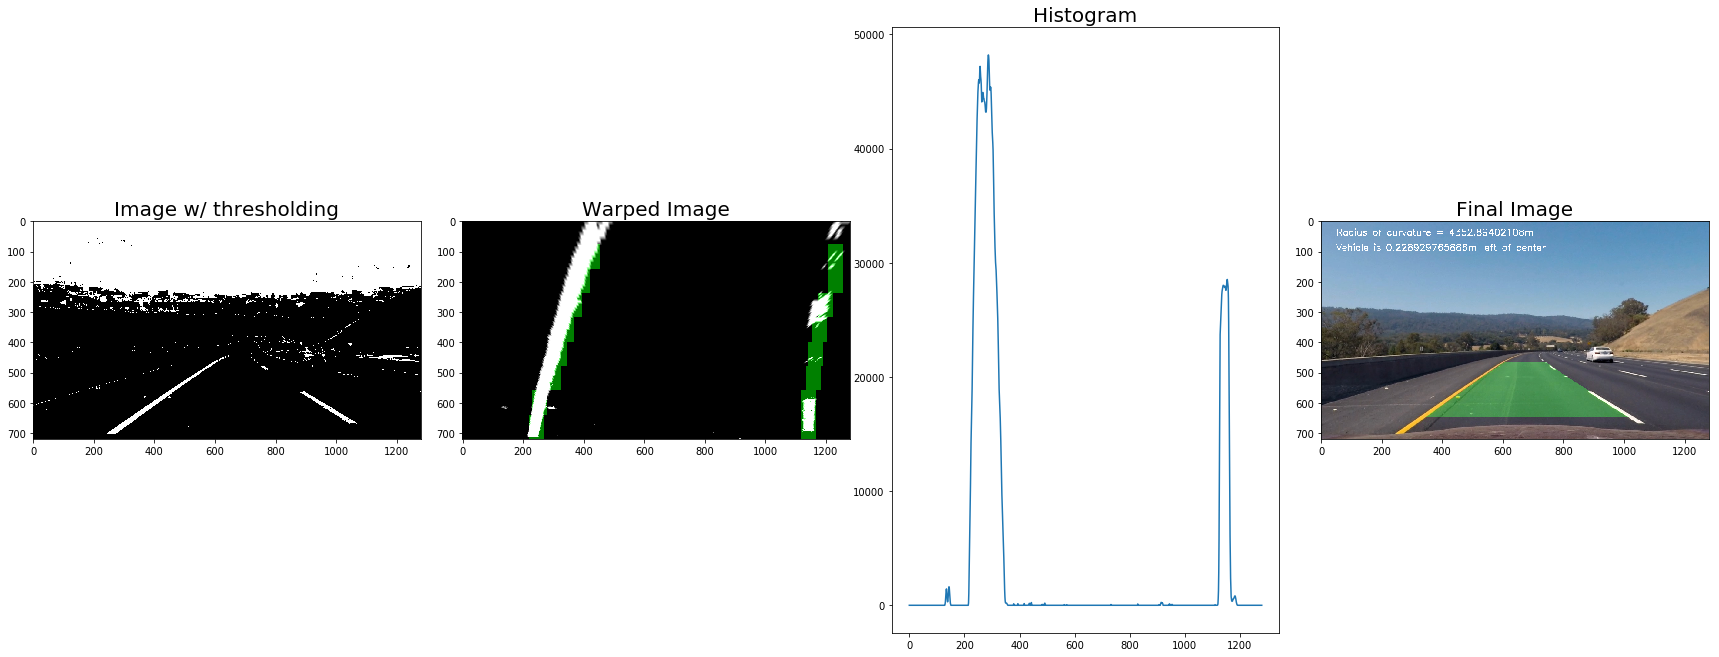

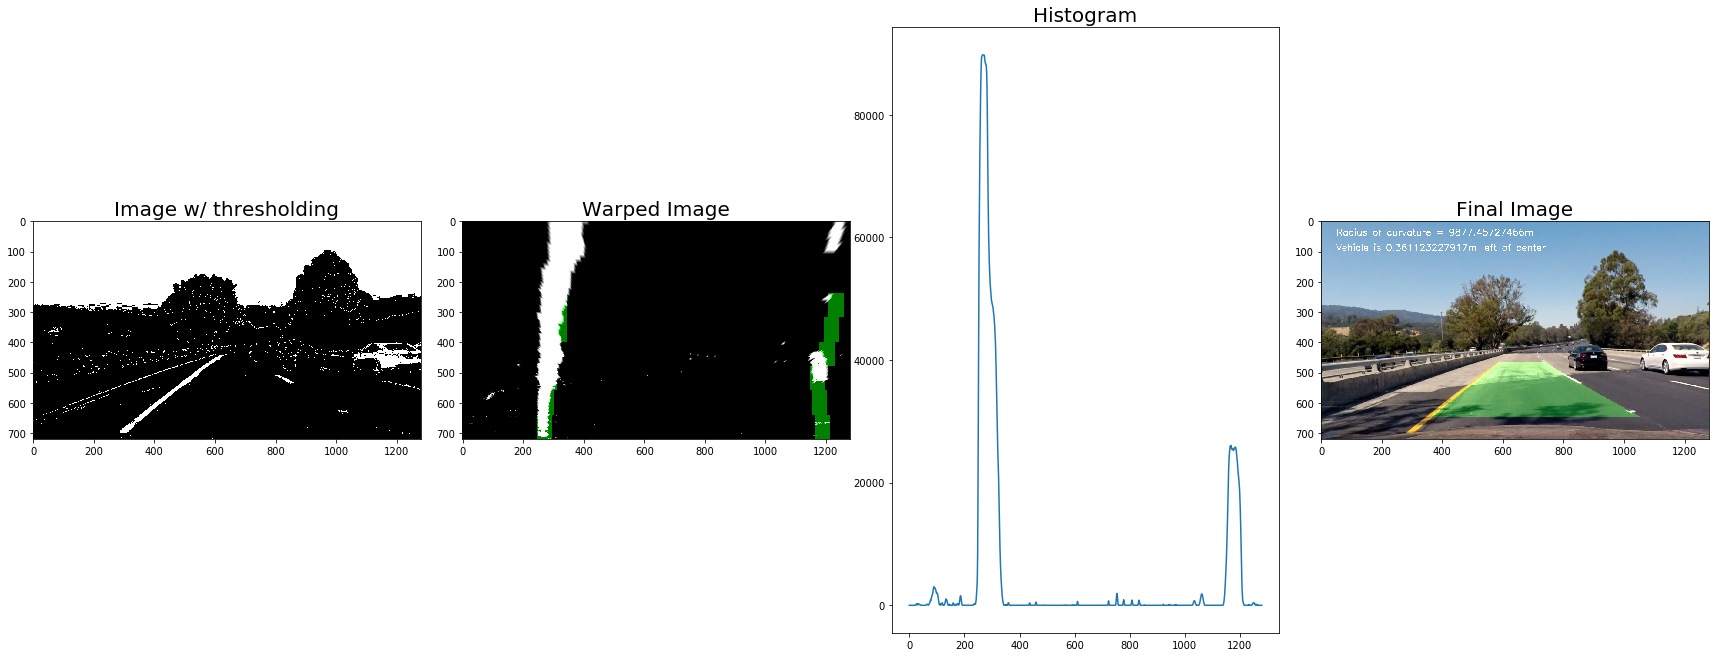

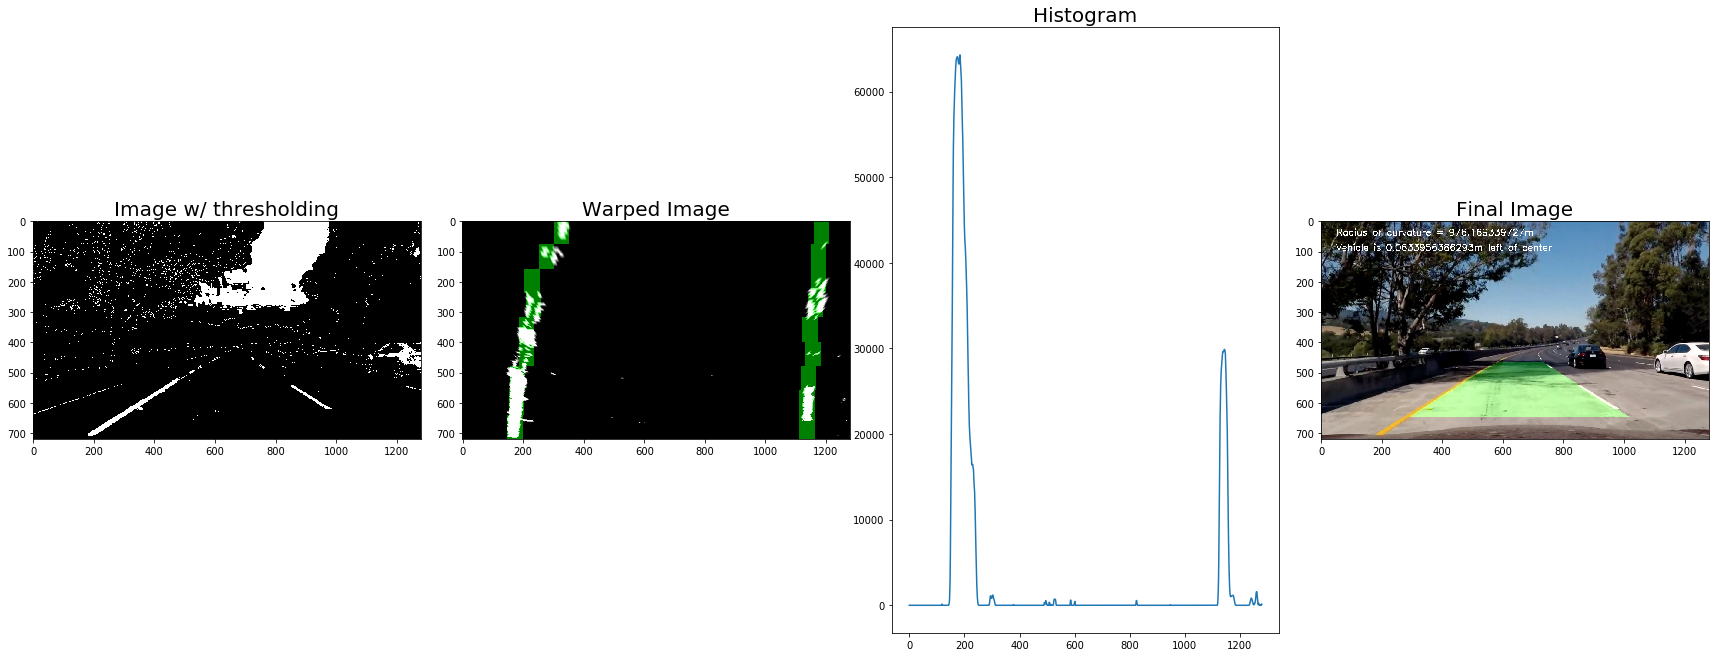

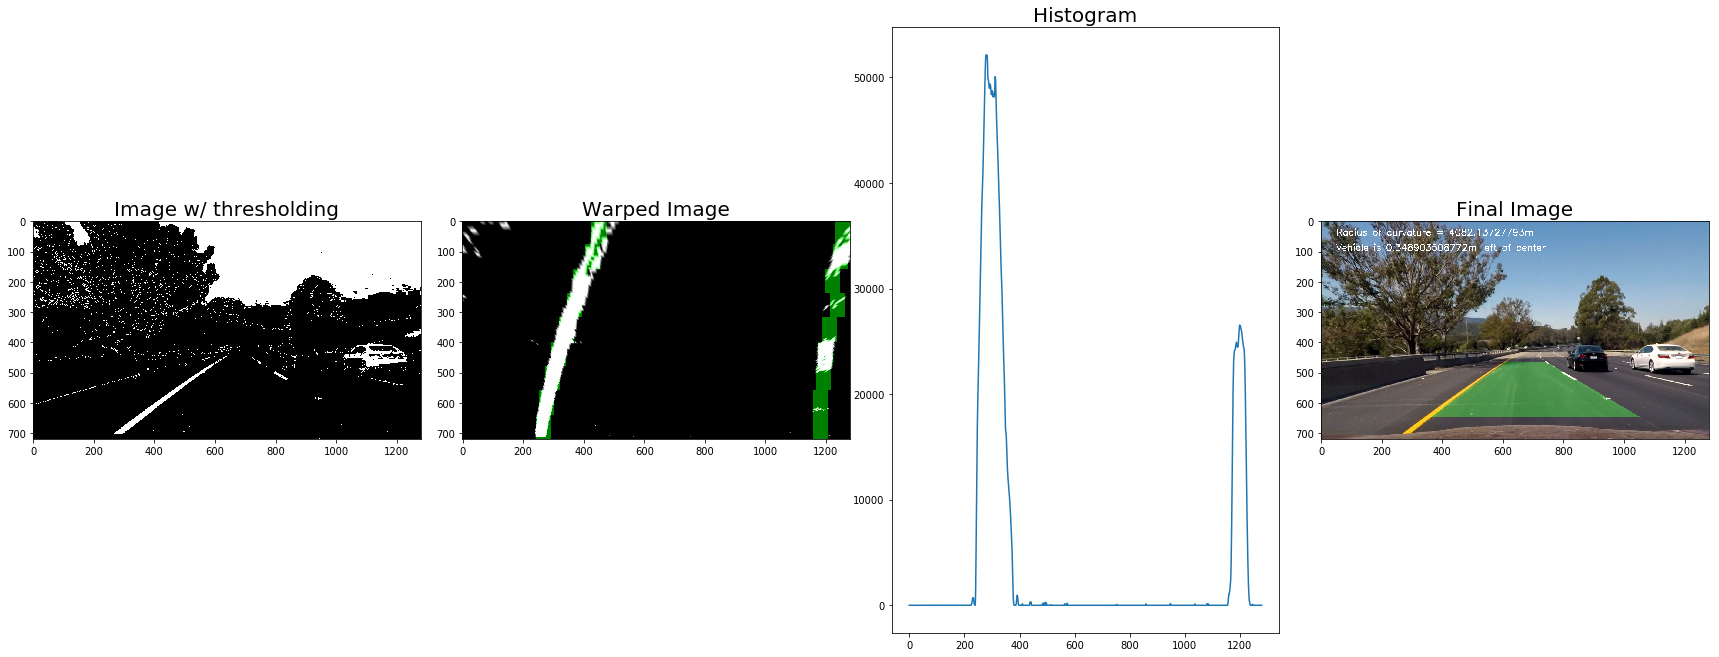

In [48]:
verbose = 1
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

        
class thresholds_cls:
    def __init__(self):
        self.thrsh_max = 255 #thrsh_max
        self.thrsh_min = 180 #thrsh_min
        

        
class window_search:
    def __init__(self):
        self.window_width = 50
        self.window_height = 80
        self.search_margin = 100
        self.recent_centers = []

        
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def correct_distortion(img):
    return cv2.undistort(img, cal_mat.mtx, cal_mat.dist, None, cal_mat.mtx)

def color_thresh(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    
    
    # Threshold color channel
    s_thresh_min = color_thresholds.thrsh_min
    s_thresh_max = color_thresholds.thrsh_max
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    
    hsv= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    # Threshold color channel
    v_thresh_min = color_thresholds.thrsh_min
    v_thresh_max = color_thresholds.thrsh_max
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1
    if (verbose > 2): print("Debug: Color thrsh (min,max) : ",s_thresh_min, s_thresh_max )
        
    output = np.zeros_like(s_binary)
    output[(s_binary == 1)& (v_binary==1)] = 1
    return output


def grad_abs_thrsh(img,sobel_kernel=3,direction='x',thresh=(100,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Sobel filtering
    if (direction == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    elif (direction == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    else:
        print ("Error using grad_abs_thrsh: Direction can only be 'x' or 'y'")
        sys.exit(1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    if (verbose > 2): print("Debug: Grad Mag thrsh (min,max) : ",thresh[0], thresh[1] )
    
    return s_binary
    
def grad_dir_thrsh(img,sobel_kernel=3,thresh=(0,np.pi/2)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan_sobelxy = np.absolute(np.arctan2(abs_sobely, abs_sobelx))
    
    scale_bin = np.zeros_like(arctan_sobelxy)
    scale_bin[(arctan_sobelxy>=thresh[0]) & (arctan_sobelxy<thresh[1])] = 1
    if (verbose > 2): print("Debug: Grad Dir thrsh (min,max) : ",thresh[0], thresh[1] )
    return scale_bin

def grad_mag_thrsh(img,sobel_kernel=3,thresh=(100,255)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Sobel filtering
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelxy = np.sqrt(np.square(np.absolute(sobelx)) + np.square(np.absolute(sobely))) 
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    s_binary = np.zeros_like(scaled_sobelxy)
    s_binary[(scaled_sobelxy >= thresh[0]) & (scaled_sobelxy <= thresh[1])] = 1
    if (verbose > 2): print("Debug: Grad Mag thrsh (min,max) : ",thresh[0], thresh[1] )
    
    return s_binary
# Combine magnitude threshold and direction threshold
def grad_thresh(img):
    
    mag_thresh_min = mag_grad_thresholds.thrsh_min
    mag_thresh_max = mag_grad_thresholds.thrsh_max
    dir_thresh_min = dir_grad_thresholds.thrsh_min
    dir_thresh_max = dir_grad_thresholds.thrsh_max
    absX_thresh_min = absX_grad_thresholds.thrsh_min
    absX_thresh_max = absX_grad_thresholds.thrsh_max
    absY_thresh_min = absY_grad_thresholds.thrsh_min
    absY_thresh_max = absY_grad_thresholds.thrsh_max
    sobel_kernel = 3
    
    mag_binary = grad_mag_thrsh(img,sobel_kernel,(mag_thresh_min,mag_thresh_max))
    dir_binary = grad_dir_thrsh(img,sobel_kernel,(dir_thresh_min,dir_thresh_max))
    absX_binary = grad_abs_thrsh(img,sobel_kernel,'x',(absX_thresh_min,absX_thresh_max))
    absY_binary = grad_abs_thrsh(img,sobel_kernel,'y',(absY_thresh_min,absY_thresh_max))
    if (verbose > 2): print("Debug Mag binary = ",mag_binary)
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1) & (absX_binary == 1) & (absY_binary == 1))] = 1
    return combined
    
def color_n_grad_thresh(img):
    color_thrsh_binary = color_thresh(img)
    grad_thrsh_binary = grad_thresh(img)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_thrsh_binary)
    combined_binary[(color_thrsh_binary == 1) | (grad_thrsh_binary == 1)] = 255

    
    image = combined_binary
    return image

# Returns src and dst points for perspective transform 
def perspective_points(img):
    img_size = (img.shape[1],img.shape[0])
    
    app_lane_center = ((img_size[0]/2),img_size[1]) # This is the expected center of the lane i.e. center of the trapezium
    height_cent = 0.25 # Height of the trapezium  as % of image Y
    bott_cent = 1.0 #0.80 # Bottom width as a % of image X
    top_cent = 0.41#0.32 # Top width as a % of image X
    
    top_width = top_cent*img_size[0]
    hgt = height_cent*img_size[1]
    bottom_width = bott_cent*img_size[0]
    coord_TL = [app_lane_center[0] - (top_width/2),img_size[1]-hgt]
    coord_TR = [app_lane_center[0] + (top_width/2),img_size[1]-hgt]
    coord_BL = [app_lane_center[0] - (bottom_width/2),img_size[1]]
    coord_BR = [app_lane_center[0] + (bottom_width/2),img_size[1]]
    
    # Coordinates of the desired rectangle
    dst_TL = [coord_BL[0],coord_TL[1]]
    dst_TR = [coord_BR[0],coord_TR[1]]
    dst_BL = coord_BL
    dst_BR = coord_BR
    
    src = np.float32([coord_TL,coord_TR,coord_BL,coord_BR])
    dst = np.float32([dst_TL,dst_TR,dst_BL,dst_BR])
    
    return src,dst

def get_window_centroids(img):
    window_centroids = []
    w_width = window_search_params.window_width
    w_hgt = window_search_params.window_height
    window = np.ones(w_width)
    search_margin = window_search_params.search_margin
    
    x_mid = int(img.shape[1]/2)
    lft_hist = np.sum(img[int(0.80*img.shape[0]):,:x_mid],axis=0)
    lft_center = np.argmax(np.convolve(window,lft_hist)) - int(w_width/2)
    rgt_hist = np.sum(img[int(0.80*img.shape[0]):,x_mid:],axis=0)
    rgt_center = np.argmax(np.convolve(window,rgt_hist)) - int(w_width/2) + x_mid
    approx_lane_width = np.absolute(lft_center - rgt_center)
    
    leftx = []
    rightx = []
    yval = []
    #Save the starting indices for left and right lanes
    window_centroids.append((lft_center,rgt_center))
    leftx.append(lft_center)
    rightx.append(rgt_center)
    yval.append(img.shape[0]-int(w_hgt/2))
    for level in range(1,int(img.shape[0]/w_hgt)):
        window_low = int(img.shape[0] - (level*w_hgt))
        window_high = int(img.shape[0] - ((level+1)*w_hgt))
        hist_layer = np.sum(img[window_high:window_low,:],axis=0)
        conv = np.convolve(window,hist_layer)
        found_lft_lane = 0
        found_rgt_lane = 0
        # Look at the previous centroid and look around that range in hist_layer
        
        l_min = int(max(lft_center+int(w_width/2) - search_margin,0))
        l_max = int(min(lft_center+int(w_width/2) + search_margin,img.shape[1]))
        if (np.max(conv[l_min:l_max]) > 0):
            found_lft_lane = 1
            lft_center = (np.argmax(conv[l_min:l_max]) - int(w_width/2) + l_min)
        
        r_min = int(max(rgt_center+int(w_width/2) - search_margin,0))
        r_max = int(min(rgt_center+int(w_width/2) + search_margin,img.shape[1]))
        if (np.max(conv[r_min:r_max]) > 0):
            found_rgt_lane = 1
            rgt_center = np.argmax(conv[r_min:r_max]) - int(w_width/2) + r_min
        if ((found_lft_lane & found_rgt_lane)):
            window_centroids.append((lft_center,rgt_center))
            leftx.append(lft_center)
            rightx.append(rgt_center)
            yval.append(window_low+int(w_hgt/2))

    return window_centroids, leftx, rightx, yval

def draw_window_centroids(warped,window_centroids):

    window_width = window_search_params.window_width
    window_height = window_search_params.window_height
# If we found any window centers
    if len(window_centroids) > 0:

        #     Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output

def draw_lane_plot(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

#Lane finding pipeline. 
def find_lane(img):
    # Undistort each frame
    undist = correct_distortion(img)
    # Threshold based on color and gradient
    binary_image = color_n_grad_thresh(undist)
    # Perspective transform
    src,dst = perspective_points(binary_image)
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(binary_image,M,(binary_image.shape[1],binary_image.shape[0]),flags=cv2.INTER_LINEAR)
    
    #Find lane centers
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    window_centroids, leftx, rightx, ploty = get_window_centroids(warped)
    # Visualize lane centers
    warped_debug = draw_window_centroids(warped,window_centroids)
    
    # Fit to find the lane boundary
    if (len(window_centroids) > 0):
        
        ploty = np.array(ploty)
        
        #print ("Debug: Lane center = ", lane_center)
        #print ("Debug: Lane Departure = ", departure_frm_ctr)
        act_lane_width = 3.7 # 3.7 m
        act_lane_len = 30 # 30 m
        x_m_per_pixel = act_lane_width/np.absolute(leftx[0]-rightx[0])
        y_m_per_pixel = act_lane_len/np.absolute(ploty[0]-ploty[-1])
    
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = (left_fit[0]*ploty*ploty) + (left_fit[1]*ploty) + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = (right_fit[0]*ploty*ploty) + (right_fit[1]*ploty) + right_fit[2]
    

        left_fit_cr = np.polyfit(np.array(ploty,np.float32)*y_m_per_pixel, np.array(leftx,np.float32)*x_m_per_pixel, 2)
        right_fit_cr = np.polyfit(np.array(ploty,np.float32)*y_m_per_pixel, np.array(rightx,np.float32)*x_m_per_pixel, 2)
        # Calculate the radii of curvature
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*y_m_per_pixel + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*y_m_per_pixel + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        lane_center = (leftx[0] + rightx[0])/2
        departure_frm_ctr = lane_center - (img.shape[1]/2) # Lane departure in 
        lane_position = 'left' if (departure_frm_ctr >= 0) else 'right'
        departure_frm_ctr_m = departure_frm_ctr*x_m_per_pixel
        
        
    
        # Draw the lane on the warped image
        img_result = draw_lane_plot(undist, warped, Minv, left_fitx, right_fitx, ploty)
        cv2.putText(img_result, 'Radius of curvature = ' + str(left_curverad) + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
        cv2.putText(img_result, 'Vehicle is ' + str(abs(departure_frm_ctr_m)) + 'm ' + lane_position+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    else:
        img_result = undist
    

    return binary_image, warped, warped_debug, histogram, img_result, left_curverad, right_curverad


for file in os.listdir("./test_images"):
    if (".jpg" in file):
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
        img = cv2.imread("./test_images" + "/" + file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Instantiate reqd objects
        color_thresholds = thresholds_cls()
        mag_grad_thresholds = thresholds_cls()
        dir_grad_thresholds = thresholds_cls()
        absX_grad_thresholds = thresholds_cls()
        absY_grad_thresholds = thresholds_cls()
        window_search_params = window_search()
      
        
        # Set parameter values
        mag_grad_thresholds.thrsh_min = 50
        mag_grad_thresholds.thrsh_max = 255
        dir_grad_thresholds.thrsh_min = 0.7
        dir_grad_thresholds.thrsh_max = 1.3
        absX_grad_thresholds.thrsh_min = 12
        absX_grad_thresholds.thrsh_max = 255
        absY_grad_thresholds.thrsh_min = 25
        absY_grad_thresholds.thrsh_max = 255
        color_thresholds.thrsh_min = 100
        color_thresholds.thrsh_max = 255
        window_search_params.window_width = 50
        window_search_params.window_height = 80
        window_search_params.search_margin = 50
        
        binary_image, top_down, warped_debug, histogram, final_image, left_curverad, right_curverad = find_lane(img_rgb)
        
        cv2.imwrite("output_images/top_down_"+file,np.uint8(top_down))
        cv2.imwrite("output_images/binary_"+file,np.uint8(binary_image))
        final_image_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)
        warped_debug_bgr = cv2.cvtColor(warped_debug, cv2.COLOR_RGB2BGR)
        cv2.imwrite("output_images/final_"+file,final_image_bgr)
        cv2.imwrite("output_images/top_down_windowed_"+file,warped_debug_bgr)
        if (1):
            f.tight_layout()
            ax1.imshow(binary_image,cmap='gray')
            ax1.set_title('Image w/ thresholding', fontsize=20)
            
            #ax2.imshow(top_down,cmap='gray')
            ax2.imshow(warped_debug)
            ax2.set_title('Warped Image', fontsize=20)
            
            ax3.plot(histogram)
            ax3.set_title('Histogram', fontsize=20)
           
    
            ax4.imshow(final_image,cmap='gray')
            ax4.set_title('Final Image', fontsize=20)


(720, 1280)


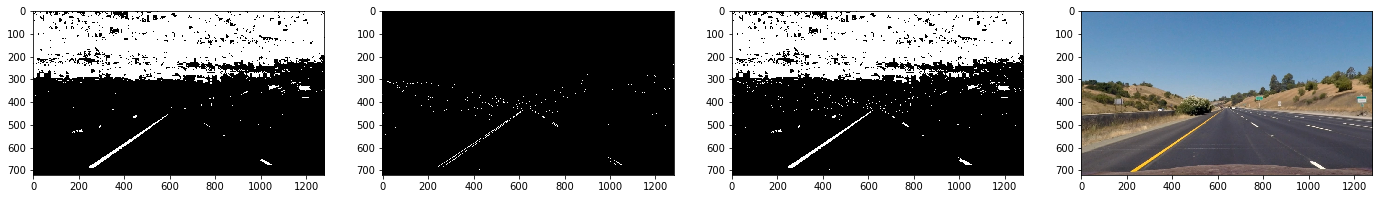

In [43]:
# Sandbox
testfile = "straight_lines1.jpg"
test_img = cv2.imread("./test_images/"+ testfile)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_undist = correct_distortion(test_img)
test_img_undist_bgr = cv2.cvtColor(test_img_undist, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/undist_"+testfile,test_img_undist_bgr)
test_img_thresh = color_thresh(test_img)
cv2.imwrite("./output_images/color_thresh_"+testfile,np.uint8(255*test_img_thresh))
test_img_grad = grad_thresh(test_img)
cv2.imwrite("./output_images/grad_thresh_"+testfile,np.uint8(255*test_img_grad))

combined_binary = np.zeros_like(test_img)
combined_binary[(test_img_thresh == 1) | (test_img_grad == 1)] = 255
print(test_img_thresh.shape)

f, (t1, t2, t3, t4) = plt.subplots(1, 4, figsize=(24, 9))
t1.imshow(test_img_thresh, cmap='gray')
t2.imshow(test_img_grad, cmap='gray')
t3.imshow(combined_binary, cmap='gray')
t4.imshow(test_img_undist)

In [33]:
 #Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def detect_lane(img_rgb):
            # Instantiate reqd objects
        binary_image, top_down, warped_debug, histogram, final_image, left_curvature, right_curvature = find_lane(img_rgb)
        
        return final_image
    
lane_output = 'project_video_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
# Instantiate reqd objects
color_thresholds = thresholds_cls()
mag_grad_thresholds = thresholds_cls()
dir_grad_thresholds = thresholds_cls()
absX_grad_thresholds = thresholds_cls()
absY_grad_thresholds = thresholds_cls()
window_search_params = window_search()
        
# Set parameter values
mag_grad_thresholds.thrsh_min = 50
mag_grad_thresholds.thrsh_max = 255
dir_grad_thresholds.thrsh_min = 0.9
dir_grad_thresholds.thrsh_max = 1.2
absX_grad_thresholds.thrsh_min = 12
absX_grad_thresholds.thrsh_max = 255
absY_grad_thresholds.thrsh_min = 25
absY_grad_thresholds.thrsh_max = 255
color_thresholds.thrsh_min = 100
color_thresholds.thrsh_max = 255
window_search_params.window_width = 50
window_search_params.window_height = 80
window_search_params.search_margin = 50
        
lane_find_fn = clip1.fl_image(detect_lane)
%time lane_find_fn.write_videofile(lane_output, audio=False)




[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


100%|█████████▉| 1260/1261 [05:36<00:00,  3.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane.mp4 

CPU times: user 5min 29s, sys: 1min 12s, total: 6min 42s
Wall time: 5min 37s
